# MNIST Digit Classification Neural Network 
# A Pure NumPy Implementation

## First implementation

In [3]:
import numpy as np

In [4]:
# A feedforward neural netowrk implementation for digit classification
# It uses ReLU activation for hidden layers and Softmax activation for the output
class NeuralNetwork:
    def __init__(self, input_neurons=784, hidden_layers=[512, 512], output_size=10):
        self.input_neurons = input_neurons
        self.hidden_layers = hidden_layers
        self.output_size = output_size

        # Lists to store the weights and biases for each layer
        self.weights = []
        self.biases = []

        # Input to first hidden layer
        self.weights.append(0.01 * np.random.randn(input_neurons, hidden_layers[0]))
        self.biases.append(np.zeros((1, hidden_layers[0])))

        # Hidden layer to hidden layer
        # For each pair of hidden layers, initialize weight and bias
        for i in range(len(hidden_layers) - 1):
            # Weight matrix between hidden layer i and i + 1
            self.weights.append(0.01 * np.random.randn(hidden_layers[i], hidden_layers[i+1]))
            # Bias vector for layer i + 1
            self.biases.append(np.zeros((1, hidden_layers[i+1])))
        
        # Last hidden layer to output
        self.weights.append(0.01 * np.random.randn(hidden_layers[len(hidden_layers)-1], output_size))
        self.biases.append(np.zeros((1, output_size)))

    # Loop through all layers (hidden + output)
    def forward(self, x_input):
        layers = [x_input] # Initialize input to the first layer

        for i in range(len(self.weights)):
            # Linear transformation: Z = A_prev @ W + b
            # - A_prev: activations from previous layer (or input)
            # - W: current layer's weights
            # - b: current layer's biases
            z = np.dot(layers[-1], self.weights[i]) + self.biases[i]
            layers.append(z)  # Store pre-activation values (needed for backprop)

            # Activation Functions (ReLU + SoftMax)
            if i == len(self.weights) - 1:
                # Output layer: apply Softmax
                # Exponentiate shifted values
                # Normalize to get probabilities (softmax)
                finalOutput = np.exp(layers[-1] - np.max(layers[-1], axis=1, keepdims=True))
                finalOutput = finalOutput / np.sum(finalOutput, axis=1, keepdims=True)
                layers.append(finalOutput)  # Append final output probabilities
            else:
                # Hidden layers: apply ReLU 
                # ReLU activation: max(0, z)
                layers.append(np.maximum(0, layers[-1]))
        
        # Return the final layer output (Softmax probabilities)
        return layers[-1]

In [5]:
# LossCategoricalCrossEntropy implementation
def LossCategoricalCrossEntropy(yPred, yTrue):
    # If predicted class has a prediction of 0% likelihood this prevents log(0), which would be infinity
    yPred = np.clip(yPred, 1e-10, 1 - 1e-10)

    # We calculate the sum of the log losses
    loss = -np.sum(yTrue * np.log(yPred), axis=1)

    # We calculate the average loss - this depends on the number of samples
    # So the return loss is the average loss not the summed up loss (which took me a while to understand)
    average_loss = np.mean(loss)

    return average_loss

In [6]:
myNeuralNet = NeuralNetwork()

In [7]:
# We finally get the predicted softmax probabilities for each of the 10 classes
result = myNeuralNet.forward(np.random.rand(1, 784))
result

array([[0.10003912, 0.09989477, 0.10003691, 0.10021514, 0.100066  ,
        0.10007754, 0.09918882, 0.10059075, 0.09945541, 0.10043555]])

## Backpropogation

In [8]:
class NeuralNetwork:
    def __init__(self, input_size=784, hidden_layers=[512, 512], output_size=10):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.weights = []
        self.biases = []
        self.gradientsWeights = []
        self.gradientsBiases = []

        # Track number of training iterations (used for learning rate decay)
        self.iterations = 0

        # Input to first hidden layer
        self.weights.append(0.01 * np.random.randn(input_size, hidden_layers[0]))
        self.biases.append(np.zeros((1, hidden_layers[0])))

        # Hidden layer to hidden layer
        # For each pair of hidden layers, initialize weight and bias
        for i in range(len(hidden_layers) - 1):
            # Weight matrix between hidden layer i and i + 1
            self.weights.append(0.01 * np.random.randn(hidden_layers[i], hidden_layers[i+1]))
            # Bias vector for layer i + 1
            self.biases.append(np.zeros((1, hidden_layers[i+1])))
        
        # Last hidden layer to output
        self.weights.append(0.01 * np.random.randn(hidden_layers[len(hidden_layers)-1], output_size))
        self.biases.append(np.zeros((1, output_size)))

    def forward(self, inputs):
        # Store outputs at each layer for use in backpropagation
        self.outputs = [inputs]  # First element is input layer output (raw input)
        self.outputsTesting = ["inputs"]  # Optional list to track layer types

        # Loop through all layers
        for i in range(len(self.weights)):
            # Perform linear transformation: Z = A_prev @ W + b
            linear_output = np.dot(self.outputs[-1], self.weights[i]) + self.biases[i]
            self.outputs.append(linear_output)  # Store linear output
            self.outputsTesting.append("dense")

            # Apply activation function
            if i == len(self.weights) - 1:
                # Output layer uses softmax activation
                shifted_logits = linear_output - np.max(linear_output, axis=1, keepdims=True)  # for numerical stability
                exp_values = np.exp(shifted_logits)
                probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
                self.outputs.append(probabilities)  # Final predicted probabilities
                self.outputsTesting.append("softmax")
            else:
                # Hidden layers use ReLU activation
                activated_output = np.maximum(0, linear_output)
                self.outputs.append(activated_output)
                self.outputsTesting.append("relu")

        return self.outputs[-1]  # Return output of last layer (Softmax probabilities)
        
    # Backpropagation step to compute gradients for all layers
    # I still don't fully understand the workings behind this
    # For now, I have understood the code and extracted it from the nnfs textbook (https://nnfs.io/)
    def backwards(self, y_true):
        # Number of training examples in batch
        samples = len(self.outputs[-1])

        # If labels are one-hot encoded, convert them to discrete values
        if len(y_true.shape) == 2:
            print("Changing to discrete values")
            y_true = np.argmax(y_true, axis=1)

        # Compute derivative of softmax + categorical crossentropy loss
        # Let's make a copy so that we can modify safely
        dSoftMaxCrossEntropy = self.outputs[-1].copy()
        # Calculate gradient
        dSoftMaxCrossEntropy[range(samples), y_true] -= 1
        # Normalize gradient
        dSoftMaxCrossEntropy /= samples
        # print(dSoftMaxCrossEntropy)

        # Calculate gradients -> Calcualte derivative of weights, biases, and inputs (to continue to backpropagate)
        dInputs = np.dot(dSoftMaxCrossEntropy.copy(), self.weights[-1].T)
        dWeights = np.dot(self.outputs[-3].T, dSoftMaxCrossEntropy.copy())
        dBiases = np.sum(dSoftMaxCrossEntropy.copy(), axis=0, keepdims=True)
        
        # Store the gradients
        self.gradientsWeights = [dWeights] + self.gradientsWeights
        self.gradientsBiases = [dBiases] + self.gradientsBiases

        # Backpropagate through hidden layers
        i = -3  # index for linear input of previous layer
        j = -1  # index for current weight layer

        for _ in range(len(self.hidden_layers)):
            i -= 1
            j -= 1

            # ReLU backward: zero out gradients where the activation was <= 0
            dReLU = dInputs.copy()
            dReLU[self.outputs[i] <= 0] = 0

            # Continue backprop
            i -= 1
            dInputs = np.dot(dReLU, self.weights[j].T)
            dWeights = np.dot(self.outputs[i].T, dReLU)
            dBiases = np.sum(dReLU, axis=0, keepdims=True)

            # Prepend to keep order aligned with layer sequence
            self.gradientsWeights = [dWeights] + self.gradientsWeights
            self.gradientsBiases = [dBiases] + self.gradientsBiases

    def updateParams(self, lr=0.05, decay=1e-7):
        # Decay the learning rate
        lr = lr * (1. / (1. + decay * self.iterations))

        # Update weights using gradient descent
        for i in range(len(self.weights) - 1):
            assert self.weights[i].shape == self.gradientsWeights[i].shape
            self.weights[i] -= lr * self.gradientsWeights[i]

        # Update biases using gradient descent
        for i in range(len(self.biases) - 1):
            assert self.biases[i].shape == self.gradientsBiases[i].shape
            self.biases[i] -= lr * self.gradientsBiases[i]

        # Increment iteration count
        self.iterations += 1

    # LossCategoricalCrossEntropy implementation
def LossCategoricalCrossEntropy(yPred, yTrue):  
    # If predicted class has a prediction of 0% likelihood this prevents log(0), which would be infinity
    yPred = np.clip(yPred, 1e-10, 1 - 1e-10)

    # We calculate the sum of the log losses
    loss = -np.sum(yTrue * np.log(yPred), axis=1)

    # We calculate the average loss - this depends on the number of samples
    # So the return loss is the average loss not the summed up loss (which took me a while to understand)
    average_loss = np.mean(loss)

    return average_loss

# Utility: convert class indices to one-hot encoded labels
def sparse_to_one_hot(sparse_labels, num_classes):
    one_hot_encoded = np.zeros((len(sparse_labels), num_classes))
    one_hot_encoded[np.arange(len(sparse_labels)), sparse_labels] = 1
    return one_hot_encoded

In [9]:
myNeuralNet = NeuralNetwork(hidden_layers=[128, 128])

In [10]:
import gzip

# Load MNIST dataset from Yann LeCun's official MNIST page (http://yann.lecun.com/exdb/mnist/)
def extract_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype=np.uint32, count=4).byteswap()
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def extract_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num = np.frombuffer(f.read(8), dtype=np.uint32, count=2).byteswap()
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

train_images = extract_images("./MNISTdata/train-images-idx3-ubyte.gz")
train_labels = extract_labels("./MNISTdata/train-labels-idx1-ubyte.gz")
test_images = extract_images("./MNISTdata/t10k-images-idx3-ubyte.gz")
test_labels = extract_labels("./MNISTdata/t10k-labels-idx1-ubyte.gz")

## MNIST Training

In [11]:
data = train_images
dataLabels = train_labels

# Let's normalize the pixel values for the NN to learn faster
data = (data.astype(np.float32)-127.5)/127.5
data = data.reshape(60000, 784)

accuracies = []
losses = []

BATCH_SIZE = 32

# Main training loop
for epoch in range(1, 3):
    print(f'epoch: {epoch}')
    # Calculate how many steps (mini-batches) there are in each epoch
    train_steps = len(data) // BATCH_SIZE 

    for step in range(train_steps):
        # Slice the current batch of 32 images and corresponding labels using step index
        batch_X = data[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        batch_Y = dataLabels[step*BATCH_SIZE:(step+1)*BATCH_SIZE]

        X = batch_X
        Y = batch_Y

        # Perform forward pass 
        output = myNeuralNet.forward(X)

        # Evaluate the model every 100 steps
        if step % 100 == 0:
            # Take the class with the highest predicted prob for each image in the batch
            predictions = np.argmax(output, axis=1)
            if len(Y.shape) == 2:
                Y = np.argmax(Y, axis=1)
            accuracy = np.mean(predictions == Y)
            
            loss = LossCategoricalCrossEntropy(output, sparse_to_one_hot(Y, 10))
            accuracies.append(accuracy)
            losses.append(loss)

            print(f'epoch: {epoch}, ' +
                    f'acc: {accuracy:.3f}, ' +
                    f'loss: {loss:.3f}')

        # Backward pass
        myNeuralNet.backwards(Y)

        # Update weights and biases
        myNeuralNet.updateParams(lr=0.5, decay=1e-6)
            

epoch: 1
epoch: 1, acc: 0.094, loss: 2.303
epoch: 1, acc: 0.438, loss: 1.491
epoch: 1, acc: 0.750, loss: 0.849
epoch: 1, acc: 0.781, loss: 0.646
epoch: 1, acc: 0.906, loss: 0.391
epoch: 1, acc: 0.844, loss: 0.548
epoch: 1, acc: 0.875, loss: 0.297
epoch: 1, acc: 0.969, loss: 0.191
epoch: 1, acc: 0.844, loss: 0.310
epoch: 1, acc: 0.969, loss: 0.181
epoch: 1, acc: 0.875, loss: 0.388
epoch: 1, acc: 0.906, loss: 0.404
epoch: 1, acc: 0.938, loss: 0.201
epoch: 1, acc: 0.875, loss: 0.358
epoch: 1, acc: 0.875, loss: 0.286
epoch: 1, acc: 0.906, loss: 0.261
epoch: 1, acc: 0.875, loss: 0.328
epoch: 1, acc: 0.906, loss: 0.226
epoch: 1, acc: 0.938, loss: 0.220
epoch: 2
epoch: 2, acc: 0.938, loss: 0.184
epoch: 2, acc: 0.844, loss: 0.353
epoch: 2, acc: 0.906, loss: 0.225
epoch: 2, acc: 1.000, loss: 0.055
epoch: 2, acc: 0.969, loss: 0.176
epoch: 2, acc: 0.906, loss: 0.220
epoch: 2, acc: 0.906, loss: 0.191
epoch: 2, acc: 0.969, loss: 0.094
epoch: 2, acc: 0.938, loss: 0.166
epoch: 2, acc: 0.969, loss: 0.

In [12]:
dataTest = test_images
dataTestLabels = test_labels

# Normalize again
dataTest = (dataTest.astype(np.float32)-127.5)/127.5

print(dataTest.shape) # (10000, 28, 28)
dataTest = dataTest.reshape(10000, 784)

X = dataTest
Y = dataTestLabels

output = myNeuralNet.forward(dataTest)

# Convert the softmax outputs into discrete class predictions (0-9)
predictions = np.argmax(output, axis=1)
if len(Y.shape) == 2:
    Y = np.argmax(Y, axis=1)

accuracy = np.mean(predictions == Y)
print(accuracy)

(10000, 28, 28)
0.943


### Plotting training metrics

Text(0, 0.5, 'Value')

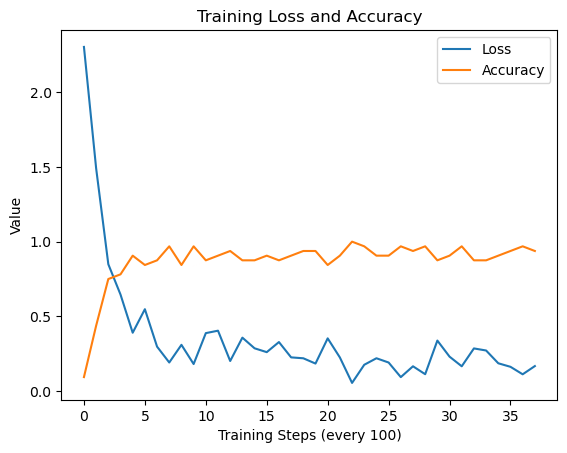

In [13]:
import matplotlib.pyplot as plt

plt.plot(losses, label = 'Loss')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Training Loss and Accuracy')
plt.xlabel('Training Steps (every 100)')
plt.ylabel('Value')

Loss Curve (blue): The loss decreases steeply at first, which is expected as the model quickly learns the basic structure of the data. It then continues to decline more slowly with some fluctuation, indicating continued (but slower) learning and possible overfitting or noisy batches.

Accuracy Curve (orange): The accuracy increases quickly and then plateaus around 90%, which is a good sign of convergence. The relatively flat plateau suggests the model is reaching its performance ceiling for the current training setup.

### Testing

Probabilities: [[9.99893144e-01 2.48227392e-10 9.52608433e-06 2.87393651e-07
  3.26044011e-08 5.81549747e-05 3.65946842e-05 3.66647608e-07
  1.07653888e-06 8.16593477e-07]]
Prediction: [0]


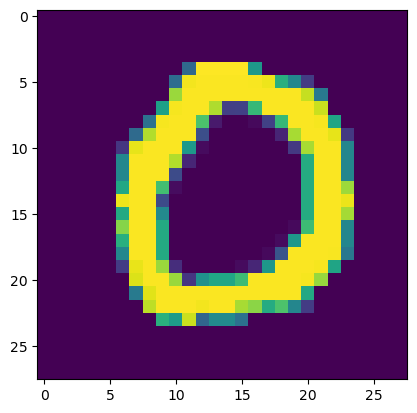

In [14]:
import matplotlib.pyplot as mp
dataTest = test_images
dataTestLabels = test_labels

# Normalize
dataTest = (dataTest.astype(np.float32)-127.5)/127.5
dataTest = dataTest.reshape(10000, 784)

X = dataTest[71]
y = dataTestLabels[71]

output = myNeuralNet.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))

Probabilities: [[7.54767436e-05 2.44192858e-06 3.23704347e-06 2.02253052e-04
  7.61827405e-05 9.98576885e-01 8.52263327e-04 1.56484732e-07
  5.31908864e-05 1.57912440e-04]]
Prediction: [5]


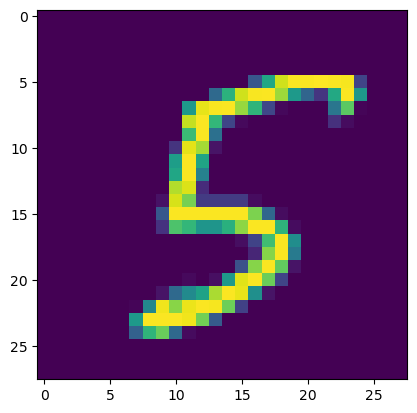

In [15]:
X = dataTest[23]
y = dataTestLabels[23]

output = myNeuralNet.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))

 In this specific example, the model predicted the digit 5 and the visualized image clearly resembles a handwritten 5. The prediction confidence is also high!
 
 Notice how the probability for class 5 is approximately 0.9985, while all other class probabilities are near zero. This indicates that our model has learned to distinguish digit patterns well and is confident in its classification. The smooth convergence shown in our earlier training loss and accuracy plot also supports this result.

Probabilities: [[4.98202601e-05 2.26270397e-05 2.59312246e-04 4.51385908e-03
  6.26483631e-03 4.68737628e-02 3.90375441e-04 5.79078084e-04
  2.61986206e-03 9.38426467e-01]]
Prediction: [9]


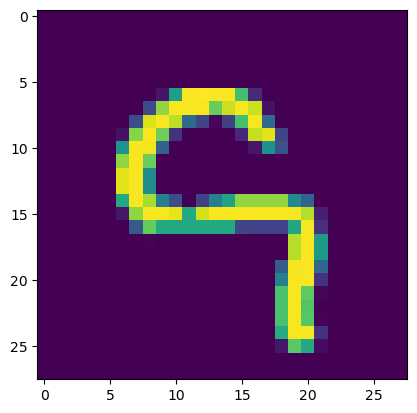

In [16]:
# This code scans through the test data (starting from index 100) to find the first digit '9' that the model correctly predicts, prints its predicted probabilities, 
# and displays the image. It's a quick sanity check to visually confirm the model's ability to correctly identify a specific digit class.

split = dataTest[100:]
splitLabels = dataTestLabels[100:]
for i in range(len(dataTest)):
    X = split[i]
    y = splitLabels[i]

    output = myNeuralNet.forward(X)
    prediction = np.argmax(output, axis=1)
    if y == 9:
        if prediction[0] == y:
            print(f"Probabilities: {output}")
            print(f"Prediction: {prediction}")

            mp.imshow(X.reshape(28, 28))
            break

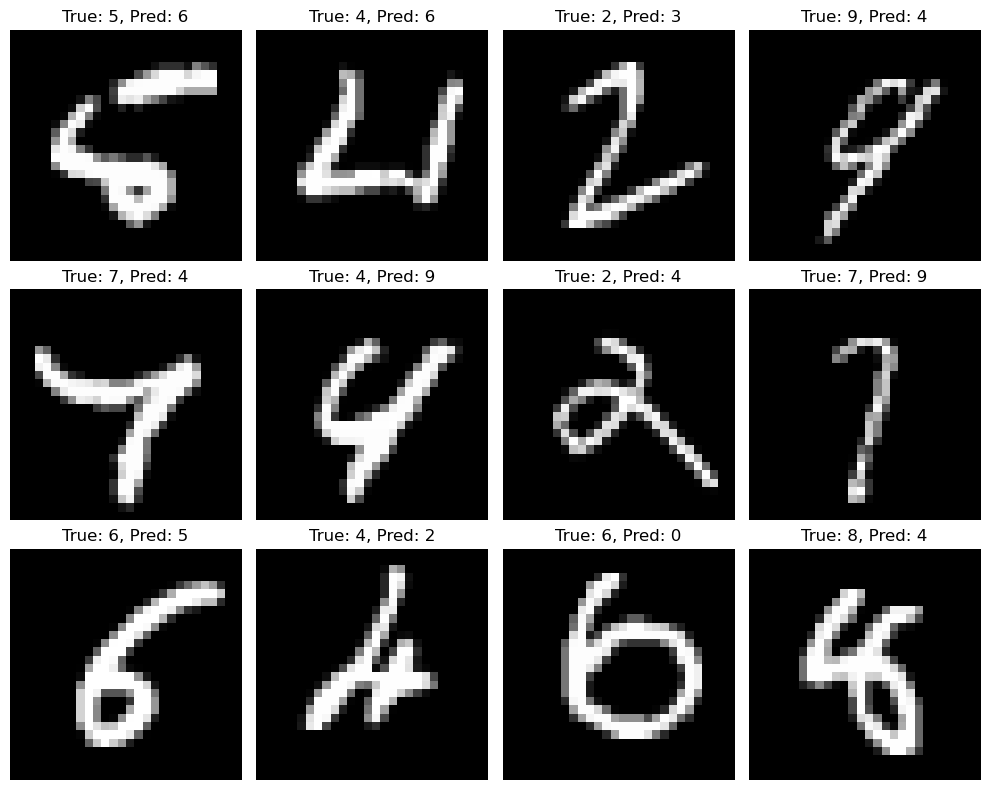

In [17]:
# Let us now identify the first 12 misclassified images from the dataset

# Initialize lists to store misclassified examples
incorrect_images = []
incorrect_labels = []
incorrect_predictions = []

# Loop over the entire test dataset
for i in range(len(dataTest)):
    X = dataTest[i]                      
    y = dataTestLabels[i]               

    output = myNeuralNet.forward(X)     # Run forward pass through the neural network
    prediction = np.argmax(output, axis=1)  # Convert output probabilities to predicted class

    # If the prediction is incorrect, store the example
    if prediction[0] != y:
        incorrect_images.append(X)              
        incorrect_labels.append(y)              
        incorrect_predictions.append(prediction[0])

        if len(incorrect_images) == 12:  
            break

# Set up a 3x4 grid for displaying 12 misclassified images
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes = axes.ravel()  # Flatten the grid to a 1D list for easy iteration

# Plot each misclassified image
for i in range(12):
    axes[i].imshow(incorrect_images[i].reshape(28, 28), cmap='gray')  
    axes[i].set_title(f'True: {incorrect_labels[i]}, Pred: {incorrect_predictions[i]}')  
    axes[i].axis('off')  # Hide axis ticks for cleaner display

plt.tight_layout()  
plt.show()          


### Fasion MNIST

Let's take it a step further and test our neural network with the Fashion MNIST dataset

In [18]:
# Download commands to get Fashion MNIST data (uncomment to run in notebook if needed)
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -P ./fashionMNIST/
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -P ./fashionMNIST/
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -P ./fashionMNIST/
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -P ./fashionMNIST/


In [19]:
# Utilized GPT to help generate the following code
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST (or Fashion MNIST) data from the specified path"""
    
    # Construct file paths for the label and image files (gzip compressed)
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    # Read and decode the label data (skip the first 8 bytes for header info)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    # Read and decode the image data (skip first 16 bytes, then reshape to 784 pixels)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels


In [20]:
X_train, y_train = load_mnist('fashionMNIST', kind='train')
X_test, y_test = load_mnist('fashionMNIST', kind='t10k')

modelFashionMNIST = NeuralNetwork(hidden_layers=[256, 256])

In [21]:
data = X_train
dataLabels = y_train

# Normalize the input data to the range [-1, 1]
data = (data.astype(np.float32)-127.5)/127.5

# Flatten the images into 784-length vectors
data = data.reshape(60000, 784)

accuracies = []
losses = []

In [ ]:
BATCH_SIZE = 32

# This is the main training loop
# Train for 2 epochs
for epoch in range(1, 3):
    print(f'epoch: {epoch}')
    train_steps = len(data) // BATCH_SIZE  # Total training steps per epoch

    for step in range(train_steps):
        # Get mini-batch
        batch_X = data[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        batch_y = dataLabels[step*BATCH_SIZE:(step+1)*BATCH_SIZE]

        X = batch_X
        y = batch_y

        output = modelFashionMNIST.forward(X)  # Forward pass

        # Every 100 steps, evaluate accuracy and loss
        if step % 100 == 0:
            predictions = np.argmax(output, axis=1)
            if len(y.shape) == 2:
                y = np.argmax(y, axis=1)
            accuracy = np.mean(predictions == y)

            loss = LossCategoricalCrossEntropy(output, sparse_to_one_hot(y, 10))
            accuracies.append(accuracy)
            losses.append(loss)

            print(f'epoch: {epoch}, ' +
                  f'acc: {accuracy:.3f}, ' +
                  f'loss: {loss:.3f}')

        # Backward pass 
        modelFashionMNIST.backwards(y)
        # Updating weights and biases
        modelFashionMNIST.updateParams(lr=0.8, decay=1e-6)


epoch: 1
epoch: 1, acc: 0.031, loss: 2.303
epoch: 1, acc: 0.562, loss: 0.993
epoch: 1, acc: 0.812, loss: 0.477
epoch: 1, acc: 0.781, loss: 0.807
epoch: 1, acc: 0.844, loss: 0.503
epoch: 1, acc: 0.656, loss: 0.919
epoch: 1, acc: 0.844, loss: 0.447
epoch: 1, acc: 0.875, loss: 0.304
epoch: 1, acc: 0.812, loss: 0.461
epoch: 1, acc: 0.844, loss: 0.472
epoch: 1, acc: 0.781, loss: 0.534
epoch: 1, acc: 0.812, loss: 0.458
epoch: 1, acc: 0.844, loss: 0.467
epoch: 1, acc: 0.719, loss: 0.710
epoch: 1, acc: 0.750, loss: 0.597
epoch: 1, acc: 0.812, loss: 0.397
epoch: 1, acc: 0.812, loss: 0.568
epoch: 1, acc: 0.812, loss: 0.488
epoch: 1, acc: 0.750, loss: 0.466
epoch: 2
epoch: 2, acc: 0.875, loss: 0.310
epoch: 2, acc: 0.781, loss: 0.402
epoch: 2, acc: 0.938, loss: 0.249
epoch: 2, acc: 0.812, loss: 0.550
epoch: 2, acc: 0.906, loss: 0.344
epoch: 2, acc: 0.844, loss: 0.758
epoch: 2, acc: 0.875, loss: 0.322
epoch: 2, acc: 0.938, loss: 0.219
epoch: 2, acc: 0.875, loss: 0.345
epoch: 2, acc: 0.906, loss: 0.

In [23]:
dataTest = X_test
dataTestLabels = y_test

# Normalize
dataTest = (dataTest.astype(np.float32)-127.5)/127.5
print(dataTest.shape)
dataTest = dataTest.reshape(10000, 784)

X = dataTest
y = dataTestLabels

output = modelFashionMNIST.forward(dataTest)

predictions = np.argmax(output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y)
print(accuracy)

(10000, 784)
0.8572


### Testing
Let's now test our NN on how effective it is identifying items of clothing

Probabilities: [[6.02459164e-07 1.21792866e-07 1.48096855e-07 1.46268353e-07
  2.03252576e-08 1.55077583e-04 6.15220991e-08 9.09968180e-03
  9.39295947e-05 9.90650211e-01]]
Label: 9
Prediction: [9]


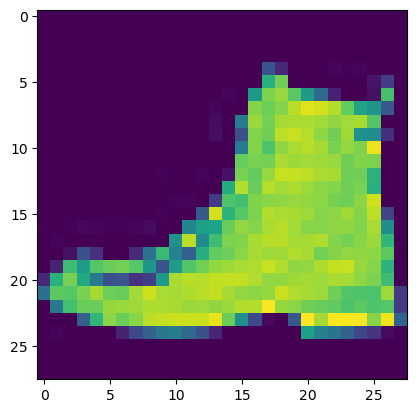

In [24]:
X = dataTest[234]
y = dataTestLabels[234]

output = modelFashionMNIST.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Label: {y}")
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))

Probabilities: [[5.05791437e-08 9.99999621e-01 5.57748775e-10 3.20934732e-07
  6.34811363e-09 2.35874219e-12 1.28592076e-10 4.54425184e-12
  8.92923603e-12 2.87368506e-12]]
Label: 1
Prediction: [1]


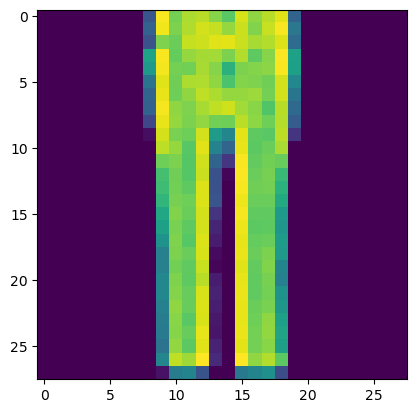

In [26]:
X = dataTest[543]
y = dataTestLabels[543]

output = modelFashionMNIST.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Label: {y}")
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))